In [4]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import skbio

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.model import other_models as om

Load and format data: 

4 control samples, 2 samples for other conditions each; 8 cell types

In [9]:
cell_counts = pd.read_csv("../data/cell_count_microglia_AD_WT_location.csv", index_col=0)
cell_counts = cell_counts.sort_values(by="mouse_type", ascending=False)
print(cell_counts)

data_cer = dat.from_pandas(cell_counts.loc[cell_counts["location"] == "cerebellum"], 
                           covariate_columns=["mouse_type", "location", "replicate"])
data_cor = dat.from_pandas(cell_counts.loc[cell_counts["location"] == "cortex"], 
                           covariate_columns=["mouse_type", "location", "replicate"])
print(data_cer.obs)

  mouse_type    location replicate  microglia 1  microglia 2  microglia 3
4         WT  cerebellum    mouse1          449            3            2
5         WT  cerebellum    mouse2          424            3            4
6         WT      cortex    mouse1          412            0            0
7         WT      cortex    mouse2          581            1            1
0         AD  cerebellum    mouse1          709            5            2
1         AD  cerebellum    mouse2          715            7            6
2         AD      cortex    mouse1          834           19           59
3         AD      cortex    mouse2          794           16          100
  mouse_type    location replicate
4         WT  cerebellum    mouse1
5         WT  cerebellum    mouse2
0         AD  cerebellum    mouse1
1         AD  cerebellum    mouse2


Plot data:

      location mouse_type     variable     value
0   cerebellum         WT  microglia 1  0.988987
1   cerebellum         WT  microglia 1  0.983759
2       cortex         WT  microglia 1  1.000000
3       cortex         WT  microglia 1  0.996569
4   cerebellum         AD  microglia 1  0.990223
5   cerebellum         AD  microglia 1  0.982143
6       cortex         AD  microglia 1  0.914474
7       cortex         AD  microglia 1  0.872527
8   cerebellum         WT  microglia 2  0.006608
9   cerebellum         WT  microglia 2  0.006961
10      cortex         WT  microglia 2  0.000000
11      cortex         WT  microglia 2  0.001715
12  cerebellum         AD  microglia 2  0.006983
13  cerebellum         AD  microglia 2  0.009615
14      cortex         AD  microglia 2  0.020833
15      cortex         AD  microglia 2  0.017582
16  cerebellum         WT  microglia 3  0.004405
17  cerebellum         WT  microglia 3  0.009281
18      cortex         WT  microglia 3  0.000000
19      cortex      

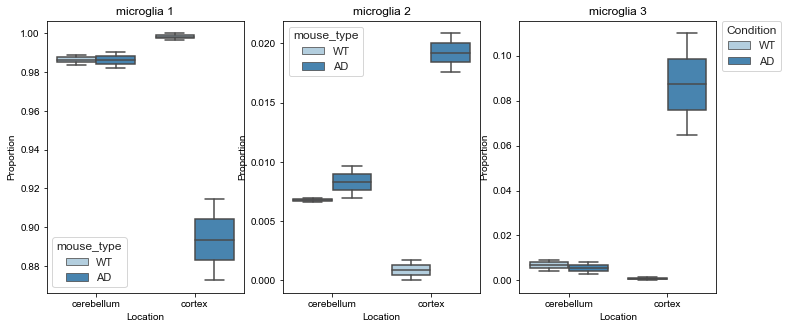

In [11]:
# Count data to ratios
counts = cell_counts.iloc[:, 3:]
rowsum = np.sum(counts, axis=1)

ratios = counts.div(rowsum, axis=0)
ratios["mouse_type"] = cell_counts["mouse_type"]
ratios["location"] = cell_counts["location"]

# Make boxplots
fig, ax = plt.subplots(figsize=(12,5), ncols=3)
df = pd.melt(ratios, id_vars=['location', "mouse_type"], value_vars=ratios.columns[:3])
print(df)
sns.set_context('notebook')
sns.set_style('ticks')
for i in range(3):
    d = sns.boxplot(x='location', y = 'value', hue="mouse_type",
                    data=df.loc[df["variable"]==f"microglia {i+1}"], fliersize=1,
                    palette='Blues', ax=ax[i])

    d.set_ylabel('Proportion')
    loc, labels = plt.xticks()
    d.set_xlabel('Location')
    d.set_title(f"microglia {i+1}")
plt.legend(bbox_to_anchor=(1.33, 1), borderaxespad=0., title="Condition")

# plt.savefig(plot_path + "haber_boxes_blue.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "haber_boxes_blue.png", format="png", bbox_inches="tight")

plt.show()

Analyze cerebellum data:
Apply scCODA for every cell type set as the reference.

In [12]:
# cerebellum
res_cer = []
effects_cer = pd.DataFrame(index=data_cer.var.index,
                       columns=data_cer.var.index)

for ct in data_cer.var.index:
    print(f"Reference: {ct}")
    
    model = mod.CompositionalAnalysis(data=data_cer, formula="mouse_type", baseline_index=ct)
    results = model.sample_hmc()
    _, effect_df = results.summary_prepare()
    res_cer.append(results)
    effects_cer[ct] = effect_df.loc[:, "Final Parameter"].array
  

Reference: microglia 1
MCMC sampling finished. (56.406 sec)
Acceptance rate: 44.1%
Reference: microglia 2
MCMC sampling finished. (53.253 sec)
Acceptance rate: 26.3%
Reference: microglia 3
MCMC sampling finished. (53.173 sec)
Acceptance rate: 50.6%


In [13]:
# Column: Reference category
# Row: Effect
print(effects_cer)
    

             microglia 1  microglia 2  microglia 3
microglia 1          0.0    14.071198    15.316415
microglia 2          0.0     0.000000    14.856027
microglia 3          0.0     5.481905     0.000000


Now with cortex data:

In [14]:
# cortex
res_cor = []
effects_cor = pd.DataFrame(index=data_cer.var.index,
                         columns=data_cer.var.index)

for ct in data_cer.var.index:
    print(f"Reference: {ct}")
    
    model = mod.CompositionalAnalysis(data=data_cor, formula="mouse_type", baseline_index=ct)
    results = model.sample_hmc()
    _, effect_df = results.summary_prepare()
    res_cor.append(results)
    effects_cor[ct] = effect_df.loc[:, "Final Parameter"].array
    

Reference: microglia 1
Zero counts encountered in data! Added a pseudocount of 0.5.
MCMC sampling finished. (53.888 sec)
Acceptance rate: 61.4%
Reference: microglia 2
Zero counts encountered in data! Added a pseudocount of 0.5.
MCMC sampling finished. (53.761 sec)
Acceptance rate: 0.5%
Reference: microglia 3
Zero counts encountered in data! Added a pseudocount of 0.5.
MCMC sampling finished. (52.768 sec)
Acceptance rate: 0.1%


In [15]:
# Column: Reference category
# Row: Effect
print(effects_cor)


             microglia 1  microglia 2  microglia 3
microglia 1     0.000000    12.202043    14.114211
microglia 2    -1.727875     0.000000    20.055638
microglia 3    -2.676171    18.300416     0.000000


Trying out: Add pseudocount of 10 to all entries
--> This really improves the results (acceptable inc.prob in all but one case)

In [16]:
# cerebellum with pseudocount
data_cer_1 = data_cer.copy()
data_cer_1.X = data_cer_1.X + 1
print(data_cer_1.X)

# Cortex with pseudocount
data_cor_1 = data_cor.copy()
data_cor_1.X = data_cor_1.X + 1
print(data_cor_1.X)

[[450.   4.   3.]
 [425.   4.   5.]
 [710.   6.   3.]
 [716.   8.   7.]]
[[413.   1.   1.]
 [582.   2.   2.]
 [835.  20.  60.]
 [795.  17. 101.]]


In [17]:
# cerebellum
res_cer_1 = []
effects_cer_1 = pd.DataFrame(index=data_cer_1.var.index,
                       columns=data_cer_1.var.index)

for ct in data_cer_1.var.index:
    print(f"Reference: {ct}")

    model = mod.CompositionalAnalysis(data=data_cer_1, formula="mouse_type", baseline_index=ct)
    results = model.sample_hmc()
    _, effect_df = results.summary_prepare()
    res_cer_1.append(results)
    effects_cer_1[ct] = effect_df.loc[:, "Final Parameter"].array


Reference: microglia 1
MCMC sampling finished. (53.224 sec)
Acceptance rate: 0.7%
Reference: microglia 2
MCMC sampling finished. (54.080 sec)
Acceptance rate: 51.4%
Reference: microglia 3
MCMC sampling finished. (53.762 sec)
Acceptance rate: 12.0%


In [18]:
# Column: Reference category
# Row: Effect
print(effects_cer_1)


             microglia 1  microglia 2  microglia 3
microglia 1     0.000000          0.0     8.706792
microglia 2     0.000000          0.0     0.000000
microglia 3     0.531081          0.0     0.000000


Now with cortex data:

In [19]:
# cortex
res_cor_1 = []
effects_cor_1 = pd.DataFrame(index=data_cor_1.var.index,
                         columns=data_cor_1.var.index)

for ct in data_cor_1.var.index:
    print(f"Reference: {ct}")

    model = mod.CompositionalAnalysis(data=data_cor_1, formula="mouse_type", baseline_index=ct)
    results = model.sample_hmc()
    _, effect_df = results.summary_prepare()
    res_cor_1.append(results)
    effects_cor_1[ct] = effect_df.loc[:, "Final Parameter"].array

Reference: microglia 1
MCMC sampling finished. (53.878 sec)
Acceptance rate: 50.6%
Reference: microglia 2
MCMC sampling finished. (54.086 sec)
Acceptance rate: 5.9%
Reference: microglia 3
MCMC sampling finished. (53.716 sec)
Acceptance rate: 1.0%


In [20]:
# Column: Reference category
# Row: Effect
print(effects_cor_1)

             microglia 1  microglia 2  microglia 3
microglia 1     0.000000    12.621649    13.454203
microglia 2    -1.593178     0.000000    19.023067
microglia 3    -2.524900    18.911114     0.000000


Now see what other models find.

First, ancom:

In [10]:
cer_ancom_result = skbio.stats.composition.ancom(
    pd.DataFrame(data_cer.X, index=data_cer.obs.index) ,
    data_cer.obs["mouse_type"]
)
print(cer_ancom_result)

cor_ancom_result = skbio.stats.composition.ancom(
    pd.DataFrame(data_cor.X + 0.5, index=data_cor.obs.index) ,
    data_cor.obs["mouse_type"]
)
print(cor_ancom_result)

(   W  Reject null hypothesis
0  0                   False
1  0                   False
2  0                   False, Percentile  0.0    25.0   50.0   75.0   100.0  0.0     25.0   50.0    75.0   \
Group          AD     AD     AD     AD     AD     WT      WT     WT      WT   
0           709.0  710.5  712.0  713.5  715.0  424.0  430.25  436.5  442.75   
1             5.0    5.5    6.0    6.5    7.0    3.0    3.00    3.0    3.00   
2             2.0    3.0    4.0    5.0    6.0    2.0    2.50    3.0    3.50   

Percentile  100.0  
Group          WT  
0           449.0  
1             3.0  
2             4.0  )
(   W  Reject null hypothesis
0  2                    True
1  1                   False
2  1                   False, Percentile  0.0     25.0   50.0    75.0   100.0  0.0     25.0   50.0    75.0   \
Group          AD      AD     AD      AD     AD     WT      WT     WT      WT   
0           794.5  804.50  814.5  824.50  834.5  412.5  454.75  497.0  539.25   
1            16.5   17.2